In [22]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os
import cycler
from scipy.stats import linregress
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [23]:
ptb7_path = "/home/gwenwhite/cmelab/ptb7-itic/ptb7-project/"
ptb7_project = signac.get_project(ptb7_path)

In [24]:
state_dict={"size": "small", 
            "process": "quench",
            "density":0.6,
            "molecule":"PTB7_5mer_smiles"}

ptb7_list= ptb7_project.find_jobs(state_dict)
for job in ptb7_list:
        rdf_path = job.fn('trajectory.gsd')

In [25]:
print(job)

9a8ae64eeafecce66f5df9b1bd17a7aa


In [26]:
def frame_get_type_position(gsdfile, typename, frame=-1):
    with gsd.hoomd.open(name=gsdfile, mode='rb') as f:
        snap = f[frame]
    typepos = snap.particles.position[
            snap.particles.typeid == snap.particles.types.index(typename)
            ]
    return typepos


def snap_bond_graph(snap):
    bond_graph = csr_matrix(
        (np.ones(snap.bonds.N), (snap.bonds.group[:, 0], snap.bonds.group[:, 1])),
        shape=(snap.particles.N, snap.particles.N),
    )
    n_components, labels = connected_components(csgraph=bond_graph, directed=False)
    return labels


def gsd_rdf(
    rdf_path,
    A_name,
    B_name,
    start=0,
    stop=None,
    rmax=None,
    rmin=0,
    bins=50,
    exclude_bonded=True):
    
    with gsd.hoomd.open(rdf_path) as t:
        snap = t[0]

        if rmax is None:
            rmax = max(snap.configuration.box[:3]) * 0.45

        rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)
        type_A = snap.particles.typeid == snap.particles.types.index(A_name)
        type_B = snap.particles.typeid == snap.particles.types.index(B_name)

        if exclude_bonded:
            molecules = snap_bond_graph(snap)
            molecules_A = molecules[type_A]
            molecules_B = molecules[type_B]
            
        for snap in t[start:stop]:
            A_pos = snap.particles.position[type_A]
            if A_name != B_name:
                B_pos = snap.particles.position[type_B]
            else:
                B_pos = A_pos

            box = snap.configuration.box
            system = (box, A_pos)
            aq = freud.locality.AABBQuery.from_system(system)
            nlist = aq.query(B_pos, {"r_max": rmax}).toNeighborList()

            if exclude_bonded:
                nlist.filter(molecules_A[nlist.point_indices]
                             != molecules_B[nlist.query_point_indices])
        for snap in t[start:]:
            rdf.compute(system=snap, reset=False)
            x = rdf.bin_centers
            y = rdf.rdf
            filename = job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
            np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
        return rdf

KeyboardInterrupt: 

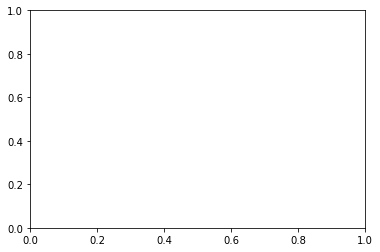

In [37]:
state_dict['density.$lt'] = 1.3
job_list = ptb7_project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for kT,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    gsdfile = rdf_path
    A_name = "ss"
    B_name = "ss"
    rdf = gsd_rdf(gsdfile, A_name, B_name, rmin=0.01, rmax=6)
    txt_path= job.fn('f-trajectory-gwen.txt')
line= np.genfromtxt(txt_path, names=True, delimiter=",")
x= line["bin_centers"]
y= line["rdf"]
plt.plot(rdf.bin_centers, rdf.rdf, label=kT)
plt.xlabel("r (A.U.)")
plt.ylabel("g(r)")
plt.title("%s and %s's at %sden" % (A_name, B_name, job.sp['density']), fontsize=16)
plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)
plt.plot(x, y, label=kT)